# Sugar Fairy
## A candy allergens detector
Food allergy is a serious issue in US. Over 5 millions children have food allergy and the number is increasing year by year according to CDC data. Among all processed food, candy is the most problematic one. Barcode and ingredient lists could be missing, especially for Halloween Candy. To solve this problem, I develop a CNN model to recognize candy and warn users for potential food allergens.   

## Data Preparation
To limit the scope of this project, I focused on 10 different common candy. Images of 10 candies (~200 each) were stoered in different sub-directories. They were resized into 224x224 and loaded into numpy array as input for CNN model. Corresponding labels was created and converted to categorical array using one-hot encoding.

In [1]:
# import common library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

# import keras library
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# connect to google drive to acquire image data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# general path to google drive
path = '/content/drive/My Drive/candy/'

# sub directory with image data
dir_list = ["kitkat",
            "m&ms p",
            "m&ms m",
            "m&ms pb",
            "snicker",
            "snicker p",
            "snicker a",
            "reese",
            "heath",
            "whopper"
           ]

In [0]:
# generate label
label = np.zeros(0)

for i in range(len(dir_list)):
  file_count = len(os.listdir(path+dir_list[i]))
  label = np.concatenate((label, np.full(file_count, i)))

In [5]:
# one-hot encoding for label column 
label = keras.utils.to_categorical(label, len(dir_list))

# sanity check
label.shape

(1994, 10)

In [0]:
# generate image dataset
data = []
for d in dir_list:
  dir_path = path + d +"/"
  
  for file in os.listdir(dir_path):
    img_path = dir_path + file
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    data.append(x)

data = np.concatenate(data, axis=0)

In [7]:
# sanity check
data.shape

(1994, 224, 224, 3)

In [0]:
# save raw data
raw_data = data[:,:,:,:]

There were a total of 1994 images of 10 diffferent types of candy. Images were in RGB color with size of 224x224. For sanity check, one example was showed below.

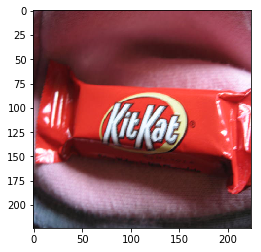

In [9]:
# example of image data
plt.imshow(data[100]/255)
plt.show()

## Transfer learning with pre-trained InceptionV3 model
I used InceptionV3, a common modern CNN model, as my base model to test the performance of CNN on candy image classification. In order to create a more robust model, I used image augmentation to increase the diversity of my training dataset. Rotation, zooming, shifting, shearing and brightness adjustment were applied randomly to generate the training data.

In [0]:
# function to preprocess data for InceptionV3 
def preprocess_inception(x):
    tmp = x/255.
    tmp -= 0.5
    tmp *= 2.
    return tmp

In [0]:
# create train test data for inceptionV3
X_train, X_test, y_train, y_test = train_test_split(preprocess_inception(data), label, test_size=0.2, random_state=1)


In [0]:
from keras.applications.inception_v3 import InceptionV3

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(256, activation='relu')(x)

# and a softmax layer for multiclass classification 
predictions = Dense(len(dir_list), activation='softmax')(x)

In [15]:
# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers 
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# set image augmentation parameter 
aug = ImageDataGenerator(rotation_range=90, zoom_range=0.2,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
  brightness_range=[0.7,1.3], fill_mode="nearest")

In [17]:
# initialize the number of epochs and batch size
EPOCHS = 5
BS = 50
 
# train the network
H = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS,
	epochs=EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
31/31 [==============================] - 32s 1s/step - loss: 2.0807 - acc: 0.3738 - val_loss: 1.5910 - val_acc: 0.4812
Epoch 2/5
31/31 [==============================] - 24s 762ms/step - loss: 1.1062 - acc: 0.6598 - val_loss: 3.0986 - val_acc: 0.3058
Epoch 3/5
31/31 [==============================] - 23s 739ms/step - loss: 0.8563 - acc: 0.7248 - val_loss: 5.0313 - val_acc: 0.2982
Epoch 4/5
31/31 [==============================] - 23s 727ms/step - loss: 0.6727 - acc: 0.7737 - val_loss: 4.1735 - val_acc: 0.2982
Epoch 5/5
31/31 [==============================] - 22s 714ms/step - loss: 0.5823 - acc: 0.8100 - val_loss: 3.8888 - val_acc: 0.3509


In [0]:
# helper function to plot result
def plot_history(hist, epochs):
  acc = hist.history["acc"]
  val_acc = hist.history["val_acc"]
  ep = range(1, len(acc)+1)
  
  plt.plot(ep, acc, "b", label="Training acc")
  plt.plot(ep, val_acc, "r", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xticks(np.arange(0, epochs+1, step=epochs/10))
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

In [21]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. 
for layer in model.layers[:197]:
   layer.trainable = False
for layer in model.layers[197:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

H = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS,
	epochs=50)

Epoch 1/50
31/31 [==============================] - 32s 1s/step - loss: 0.6202 - acc: 0.7953 - val_loss: 1.2777 - val_acc: 0.5739
Epoch 2/50
31/31 [==============================] - 26s 835ms/step - loss: 0.3862 - acc: 0.8842 - val_loss: 0.9601 - val_acc: 0.6541
Epoch 3/50
31/31 [==============================] - 26s 836ms/step - loss: 0.3217 - acc: 0.9086 - val_loss: 0.8555 - val_acc: 0.6942
Epoch 4/50
31/31 [==============================] - 26s 827ms/step - loss: 0.2621 - acc: 0.9338 - val_loss: 0.8088 - val_acc: 0.7193
Epoch 5/50
31/31 [==============================] - 26s 824ms/step - loss: 0.2720 - acc: 0.9219 - val_loss: 0.7530 - val_acc: 0.7343
Epoch 6/50
31/31 [==============================] - 27s 868ms/step - loss: 0.2500 - acc: 0.9282 - val_loss: 0.7029 - val_acc: 0.7569
Epoch 7/50
31/31 [==============================] - 24s 776ms/step - loss: 0.2254 - acc: 0.9348 - val_loss: 0.6797 - val_acc: 0.7694
Epoch 8/50
31/31 [==============================] - 25s 792ms/step - los

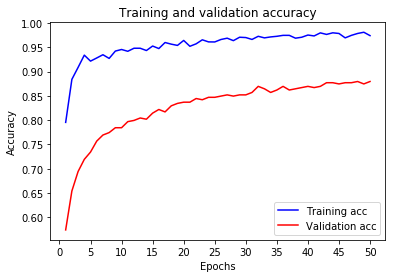

In [22]:
# plot result
plot_history(H, 50)

It looked like the model still have room for improvement. To speed up the training, I used a much higher learning rate to facilitate learning.    

In [25]:
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

H = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS,
	epochs=30)

Epoch 1/30
31/31 [==============================] - 31s 999ms/step - loss: 0.0051 - acc: 0.9994 - val_loss: 0.1677 - val_acc: 0.9424
Epoch 2/30
31/31 [==============================] - 25s 820ms/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.2953 - val_acc: 0.9048
Epoch 3/30
31/31 [==============================] - 25s 816ms/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.2239 - val_acc: 0.9323
Epoch 4/30
31/31 [==============================] - 25s 798ms/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.2277 - val_acc: 0.9298
Epoch 5/30
31/31 [==============================] - 25s 799ms/step - loss: 0.0050 - acc: 0.9987 - val_loss: 0.2322 - val_acc: 0.9323
Epoch 6/30
31/31 [==============================] - 25s 798ms/step - loss: 0.0035 - acc: 0.9987 - val_loss: 0.4267 - val_acc: 0.8647
Epoch 7/30
31/31 [==============================] - 25s 806ms/step - loss: 0.0117 - acc: 0.9981 - val_loss: 0.3753 - val_acc: 0.8972
Epoch 8/30
31/31 [==============================] - 25s 806ms/step - 

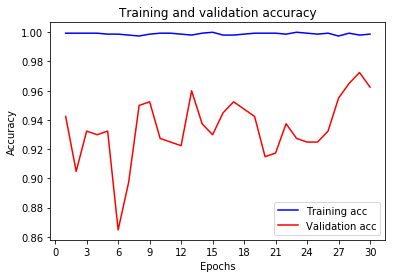

In [26]:
# plot result
plot_history(H, 30)

In [27]:
# check prediction result
pred = model.predict(X_test)

# show confusion matrix
table = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print(table)

acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print(f'Overall accuracy: {round(acc, 3)}')

[[40  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  3  0  0  0  0  0  0]
 [ 0  0 29  6  0  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0  0  0]
 [ 0  0  0  0 31  0  1  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0]
 [ 0  0  0  0  0  2 38  0  0  0]
 [ 0  0  0  0  0  1  0 34  0  0]
 [ 1  0  0  0  0  0  1  0 46  0]
 [ 0  0  0  0  0  0  0  0  0 43]]
Overall accuracy: 0.962


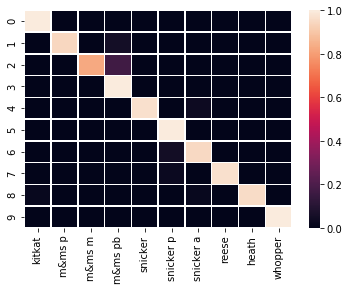

In [28]:
# function to show heatmap
def plot_matrix(t):
  tmp = t/t.sum(axis=1)[:,None]
  tmp = pd.DataFrame(tmp)
  tmp.columns = dir_list
  tmp.rename(index={0: 'kitkat', 1: 'm&ms p', 2: 'm&ms m', 3: 'm&ms pb',
           4: 'snicker', 5: 'snicker p', 6: 'snicker a', 7: 'reese', 8: 'heath'})

  ax = heatmap(tmp, linewidths=0.5)
  
plot_matrix(table)

Using transfer learning approach with InceptionV3 model, I could archieve about 96% accuracy in candy classification. However, it did not perform very well in classifying M&Ms peanut butter and M&Ms chocolate. Let's me explored a little more with other model for comparison.




## Transfer learning with pre-trained ResNet50 model
Next, I tried another modern CNN model, ResNet50. 

In [43]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len(dir_list), activation='softmax')(x)

# this is the model we will train
model_res = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_res.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
from keras.applications.resnet50 import preprocess_input
X_train, X_test, y_train, y_test = train_test_split(preprocess_input(data), label, test_size=0.2, random_state=123)

In [46]:
# initialize the number of epochs and batch size
EPOCHS = 5
BS = 50
 
# train the network
R = model_res.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS,
	epochs=EPOCHS)

Epoch 1/5
31/31 [==============================] - 32s 1s/step - loss: 1.5867 - acc: 0.6053 - val_loss: 0.9753 - val_acc: 0.6516
Epoch 2/5
31/31 [==============================] - 26s 829ms/step - loss: 0.3787 - acc: 0.8834 - val_loss: 0.7943 - val_acc: 0.7569
Epoch 3/5
31/31 [==============================] - 26s 850ms/step - loss: 0.2146 - acc: 0.9353 - val_loss: 0.8180 - val_acc: 0.7594
Epoch 4/5
31/31 [==============================] - 25s 819ms/step - loss: 0.1837 - acc: 0.9367 - val_loss: 1.1466 - val_acc: 0.6692
Epoch 5/5
31/31 [==============================] - 25s 809ms/step - loss: 0.1702 - acc: 0.9454 - val_loss: 1.1955 - val_acc: 0.7243


In [48]:
# re-train the last 2 blocks
for layer in model_res.layers[:80]:
   layer.trainable = False
for layer in model_res.layers[80:]:
   layer.trainable = True

model_res.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

R = model_res.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS, epochs=50)



Epoch 1/50
31/31 [==============================] - 43s 1s/step - loss: 0.0349 - acc: 0.9923 - val_loss: 0.0701 - val_acc: 0.9749
Epoch 2/50
31/31 [==============================] - 31s 1s/step - loss: 0.0150 - acc: 0.9974 - val_loss: 0.0954 - val_acc: 0.9649
Epoch 3/50
31/31 [==============================] - 31s 996ms/step - loss: 0.0118 - acc: 0.9955 - val_loss: 0.0866 - val_acc: 0.9699
Epoch 4/50
31/31 [==============================] - 31s 992ms/step - loss: 0.0055 - acc: 0.9981 - val_loss: 0.0556 - val_acc: 0.9774
Epoch 5/50
31/31 [==============================] - 31s 986ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9799
Epoch 6/50
31/31 [==============================] - 30s 979ms/step - loss: 0.0075 - acc: 0.9987 - val_loss: 0.0395 - val_acc: 0.9799
Epoch 7/50
31/31 [==============================] - 30s 979ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 0.0537 - val_acc: 0.9749
Epoch 8/50
31/31 [==============================] - 30s 969ms/step - loss: 

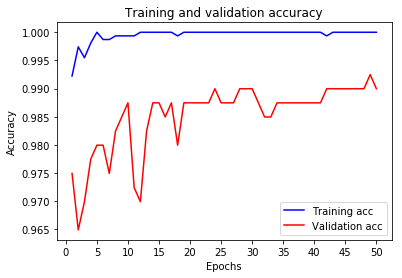

In [49]:
# plot result
plot_history(R, 50)


In [50]:
# check prediction result
pred = model_res.predict(X_test)

# show confusion matrix
table = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print(table)

acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print(f'Overall accuracy: {round(acc, 3)}')

[[42  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 30  2  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0 41  0  1  0  0  0]
 [ 0  0  0  0  0 38  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0  0  0 42  0]
 [ 1  0  0  0  0  0  0  0  0 38]]
Overall accuracy: 0.99


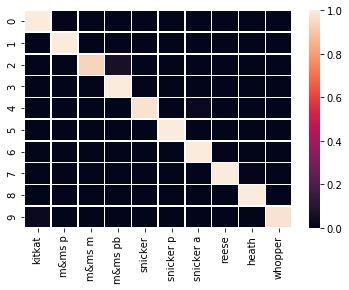

In [51]:
plot_matrix(table)

For ResNet50, the result was very encouraging. Overall validation accuracy was around 99% with some difficulty only in distinguishing M&Ms chocolate and peanut butter. I decided to focus on this model and fine tune it in the production codes. 

## Identifying probability cutoff
Even with such high accuracy, missclassification was still an issue since users could provide images of candy that did not belong to the 10 classes. To avoid such case, I analyze the classification probability to determine a cutoff. First, let's looked at the probability of all the correct an wrong classification.  

In [52]:
# create dataframe contains test result
result = pd.DataFrame({'Prob': np.amax(pred, axis=1),'truth': np.argmax(y_test, axis=1), 'predict': np.argmax(pred, axis=1)})

result['correct'] = result['truth']==result['predict']

result.head(5)

,Prob,truth,predict,correct
0,0.653258,9,9,True
1,0.999992,4,4,True
2,0.999998,6,6,True
3,1.000000,4,4,True
4,1.000000,7,7,True


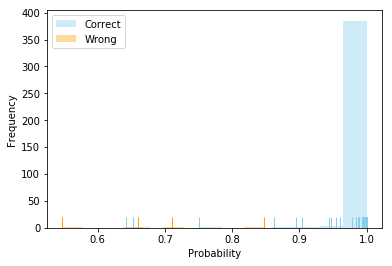

In [53]:
sns.distplot(result['Prob'][result['correct']==True] , bins=10, color="skyblue", label="Correct", kde=False, rug=True)
sns.distplot(result['Prob'][result['correct']!=True] , bins=10, color="orange", label="Wrong", kde=False, rug=True)
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

The above figure showed that all mis-classification had probability lower than 0.9. For correct classification, most of them have probability over 0.9. In this case, I decided to use 0.9 as my cutoff. Unless the model prediction with classification probability over 0.9, the model would not assign the image to particular candy class.

## Summary
Both InceptionV3 and ResNet50 performed very well in this project wiht >95% accuracy. However, there were some limitations. For input images dataset, rotation was used with left or right turn of 90 degree. It means that the model may not be able to detect image that are flipped vertically. Increasing the degree in augmentation led to significant decrease in model accuracy. Since this model was used for allergens detection, decrease in accuracy should be avoided if possible.   